# Import Libraries and Load datasets

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import datetime as dt

% matplotlib inline
seed = 129

# Import Data

path = 'input/'

transactions = pd.read_csv(path+'transactions_v2.csv',parse_dates=['transaction_date','membership_expire_date'], dtype={'payment_method_id':np.int8,'payment_plan_days':np.int8,'plan_list_price':np.int8,'actual_amount_paid':np.int8,'is_auto_renew':np.int8,'is_cancel':np.int8})
train = pd.read_csv(path+'train_v2.csv',dtype={'is_churn':np.int8})

test = pd.read_csv(path+'sample_submission_v2.csv',dtype={'is_churn':np.int8})

members = pd.read_csv(path+'members_v3.csv',parse_dates=['registration_init_time'],dtype={'city':np.int8,'bd':np.int8,'registered_via':np.int8})



user_log = pd.read_csv(path+'user_logs_v2.csv',parse_dates=['date'],dtype={'num_25':np.int16,'num_50':np.int16, 'num_75':np.int16,'num_985':np.int16,'num_100':np.int16,'num_unq':np.int16})



# User Log dataset info

In [2]:
print('User Log Data : Number of rows & columns',user_log.shape)
user_log.head()

User Log Data : Number of rows & columns (18396362, 9)


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,2017-03-31,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,2017-03-30,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,2017-03-31,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,2017-03-31,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,2017-03-31,2,1,0,1,112,93,28401.558


# Transactions dataset info

In [3]:
print('Transactions Data : Number of rows & columns',transactions.shape)
transactions.head()

Transactions Data : Number of rows & columns (1431009, 9)


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,42,42,0,2017-01-31,2017-05-04,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,-107,-107,1,2015-08-09,2019-04-12,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,-76,-76,1,2017-03-03,2017-04-22,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,-76,-76,1,2017-03-29,2017-03-31,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,2017-03-23,2017-04-23,0


# Members dataset info

In [4]:
print('Members Data : Number of rows & columns',members.shape)
members.head()

Members Data : Number of rows & columns (6769473, 6)


,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,2011-09-11
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,2011-09-14
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,2011-09-15
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,2011-09-15
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,2011-09-15


# Test dataset info

In [5]:
print('Test Data : Number of rows & columns',test.shape)
test.head()

Test Data : Number of rows & columns (907471, 2)


,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0


# Train dataset info

In [6]:
print('Train Data : Number of rows & columns',train.shape)
train.head()

Train Data : Number of rows & columns (970960, 2)


,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


# All dataset column descrption

In [7]:
print('\nTrain:',train.describe().T)
print('\nTest:',test.describe().T)
print('\nMembers:',members.describe().T)
print('\nTransactions:',transactions.describe().T)
print('\nUser log:',user_log.describe().T)


Train:              count      mean       std  min  25%  50%  75%  max
is_churn  970960.0  0.089942  0.286099  0.0  0.0  0.0  0.0  1.0

Test:              count  mean  std  min  25%  50%  75%  max
is_churn  907471.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

Members:                     count      mean        std    min  25%  50%   75%    max
city            6769473.0  3.847358   5.478359    1.0  1.0  1.0   4.0   22.0
bd              6769473.0  9.763688  15.354561 -128.0  0.0  0.0  21.0  126.0
registered_via  6769473.0  5.253069   2.361398   -1.0  4.0  4.0   7.0   19.0

Transactions:                         count       mean        std    min    25%   50%   75%  \
payment_method_id   1431009.0  37.918355   4.964805    2.0   36.0  40.0  41.0   
payment_plan_days   1431009.0  18.432050  39.830162 -117.0   30.0  30.0  30.0   
plan_list_price     1431009.0 -21.387690  94.768896 -127.0 -107.0 -76.0  99.0   
actual_amount_paid  1431009.0 -20.556024  94.926916 -127.0 -107.0 -76.0  99.0   
is_auto_r

# Merge Train & Test dataset with Members, Trasanctions & User Logs

In [8]:
train = pd.merge(train,members,on='msno',how='left')
test = pd.merge(test,members,on='msno',how='left')
train = pd.merge(train,transactions,how='left',on='msno',left_index=True, right_index=True)
test = pd.merge(test,transactions,how='left',on='msno',left_index=True, right_index=True,)
train = pd.merge(train,user_log,how='left',on='msno',left_index=True, right_index=True)
test = pd.merge(test,user_log,how='left',on='msno',left_index=True, right_index=True)

del members,transactions,user_log
print('Number of rows & columns',train.shape)
print('Number of rows & columns',test.shape)

Number of rows & columns (970960, 23)
Number of rows & columns (907471, 23)


# Generate descriptive statistics on date columns

In [9]:
train[['registration_init_time' ,'transaction_date','membership_expire_date','date']].describe()

,registration_init_time,transaction_date,membership_expire_date,date
count,860967,970960,970960,970960
unique,4749,820,1818,31
top,2015-10-09 00:00:00,2017-03-31 00:00:00,2017-04-30 00:00:00,2017-03-30 00:00:00
freq,1575,130414,79283,32331
first,2004-03-26 00:00:00,2015-01-01 00:00:00,2016-04-20 00:00:00,2017-03-01 00:00:00
last,2017-04-24 00:00:00,2017-03-31 00:00:00,2036-10-15 00:00:00,2017-03-31 00:00:00


# Find null value count for date columns

In [10]:
train[['registration_init_time' ,'transaction_date','membership_expire_date','date']].isnull().sum()

registration_init_time    109993
transaction_date               0
membership_expire_date         0
date                           0
dtype: int64

# Update null values with default values - registration_init_time

In [11]:
train['registration_init_time'] = train['registration_init_time'].fillna(value=pd.to_datetime('09/10/2015'))
test['registration_init_time'] = test['registration_init_time'].fillna(value=pd.to_datetime('09/10/2015'))

# Feature Genration :- Create numerical columns of date columns

In [12]:
def date_feature(df):
    
    col = ['registration_init_time' ,'transaction_date','membership_expire_date','date']
    var = ['reg','trans','mem_exp','user_']
    #df['duration'] = (df[col[1]] - df[col[0]]).dt.days 
    
    for i ,j in zip(col,var):
        df[j+'_day'] = df[i].dt.day.astype('uint8')
        df[j+'_weekday'] = df[i].dt.weekday.astype('uint8')        
        df[j+'_month'] = df[i].dt.month.astype('uint8') 
        df[j+'_year'] =df[i].dt.year.astype('uint16') 

date_feature(train)
date_feature(test)

# Find null value columns in numerical columns

In [13]:
train.isnull().sum()

msno                           0
is_churn                       0
city                      109993
bd                        109993
gender                    582055
registered_via            109993
registration_init_time         0
payment_method_id              0
payment_plan_days              0
plan_list_price                0
actual_amount_paid             0
is_auto_renew                  0
transaction_date               0
membership_expire_date         0
is_cancel                      0
date                           0
num_25                         0
num_50                         0
num_75                         0
num_985                        0
num_100                        0
num_unq                        0
total_secs                     0
reg_day                        0
reg_weekday                    0
reg_month                      0
reg_year                       0
trans_day                      0
trans_weekday                  0
trans_month                    0
trans_year

# Update null values with default values

In [14]:
col = [ 'city', 'bd', 'gender', 'registered_via']
def missing(df,columns):
    col = columns
    for i in col:
        df[i].fillna(df[i].mode()[0],inplace=True)

missing(train,col)
missing(test,col)

# Label encoder - Gender column

In [15]:
# Encode Label to vlaues 0 or 1. That is male, female to 0-1.
le = LabelEncoder()
train['gender'] = le.fit_transform(train['gender'])
test['gender'] = le.fit_transform(test['gender'])

# Feature Generation - discount, is_discount, membership_duration & registration_duration

In [16]:
train['discount'] = train['plan_list_price'] - train['actual_amount_paid']
test['discount'] = test['plan_list_price'] - test['actual_amount_paid']

train['is_discount'] = train.discount.apply(lambda x: 1 if x > 0 else 0)
test['is_discount'] = test.discount.apply(lambda x: 1 if x > 0 else 0)



In [17]:
train['membership_duration'] = train.membership_expire_date - train.transaction_date
train['membership_duration'] = train['membership_duration'] / np.timedelta64(1, 'D')
train['membership_duration'] = train['membership_duration'].astype(int)

test['membership_duration'] = test.membership_expire_date - test.transaction_date
test['membership_duration'] = test['membership_duration'] / np.timedelta64(1, 'D')
test['membership_duration'] = test['membership_duration'].astype(int)

In [18]:
train['registration_duration'] = train.membership_expire_date - train.registration_init_time
train['registration_duration'] = train['registration_duration'] / np.timedelta64(1, 'D')
train['registration_duration'] = train['registration_duration'].astype(int)

test['registration_duration'] = test.membership_expire_date - test.registration_init_time
test['registration_duration'] = test['registration_duration'] / np.timedelta64(1, 'D')
test['registration_duration'] = test['registration_duration'].astype(int)


In [19]:
train['autorenew_&_not_cancel'] = ((train.is_auto_renew == 1) == (train.is_cancel == 0)).astype(np.int8)

test['autorenew_&_not_cancel'] = ((test.is_auto_renew == 1) == (test.is_cancel == 0)).astype(np.int8)

In [20]:
train['notAutorenew_&_cancel'] = ((train.is_auto_renew == 0) == (train.is_cancel == 1)).astype(np.int8)

test['notAutorenew_&_cancel'] = ((test.is_auto_renew == 0) == (test.is_cancel == 1)).astype(np.int8)

# is_Churn

Text(0.5,0,'The subscription within 30 days of expiration is True/False')

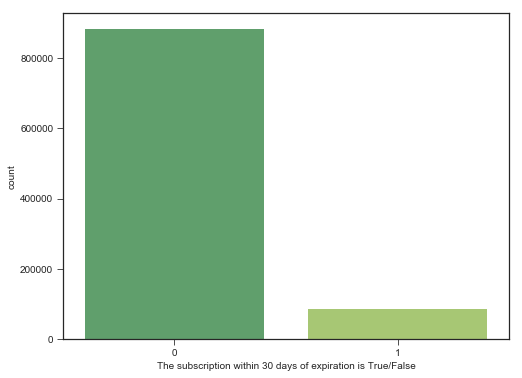

In [21]:
plt.figure(figsize=(8,6))
sns.set_style('ticks')
sns.countplot(train['is_churn'],palette='summer')
plt.xlabel('The subscription within 30 days of expiration is True/False')

# Data Analysis

[ 5. 13.  1. 22.  9. 12.  6. 14.  4. 15. 18.  3. 21.  8.  7. 17. 11. 10.
 20. 16. 19.]


Text(0.5,0,'Payment_method_id')

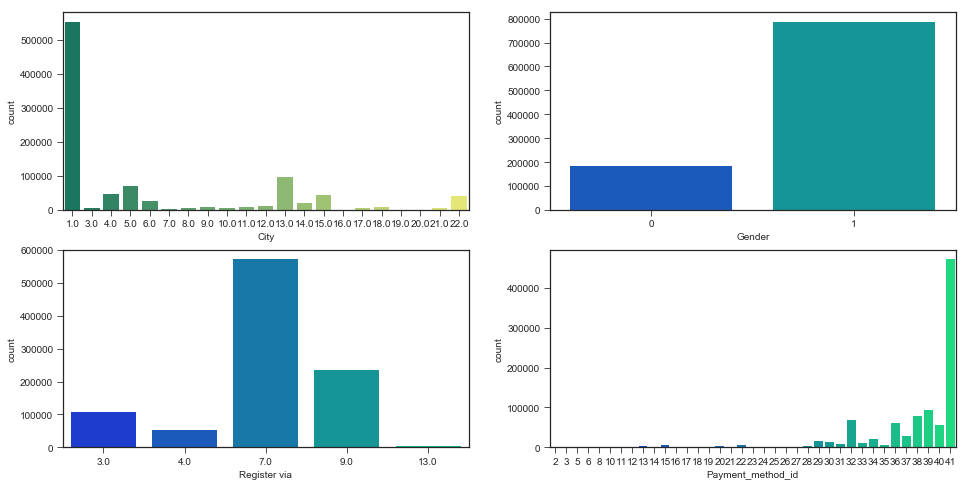

In [22]:
print(train['city'].unique())
fig,ax = plt.subplots(2,2,figsize=(16,8))
ax1,ax2,ax3,ax4 = ax.flatten()

sns.set(style="ticks")
sns.countplot(train['city'],palette='summer',ax=ax1)
#ax1.set_yscale('log')

ax1.set_xlabel('City')
#ax1.set_xticks(rotation=45)

sns.countplot(x='gender',data = train,palette='winter',ax=ax2)
#ax2.set_yscale('log')
ax2.set_xlabel('Gender')

sns.countplot(x='registered_via',data=train,palette='winter',ax=ax3)
#ax3.set_yscale('')
ax3.set_xlabel('Register via')

sns.countplot(x='payment_method_id',data= train,palette='winter',ax=ax4)
ax4.set_xlabel('Payment_method_id')

# Gender : 0 - Femal, 1 - Male

In [23]:
print(pd.crosstab(train['is_churn'],train['gender']))

gender         0       1
is_churn                
0         160404  723226
1          23940   63390


# Registration init time

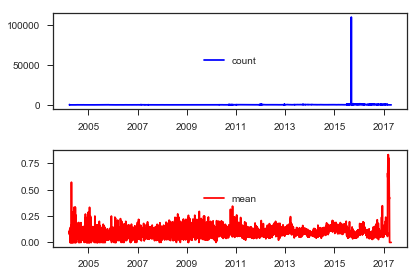

In [24]:
regi = train.groupby('registration_init_time').count()['is_churn']
plt.subplot(211)
plt.plot(regi,color='b',label='count')
plt.legend(loc='center')
regi = train.groupby('registration_init_time').mean()['is_churn']
plt.subplot(212)
plt.plot(regi,color='r',label='mean')
plt.legend(loc='center')
plt.tight_layout()

#  Registration

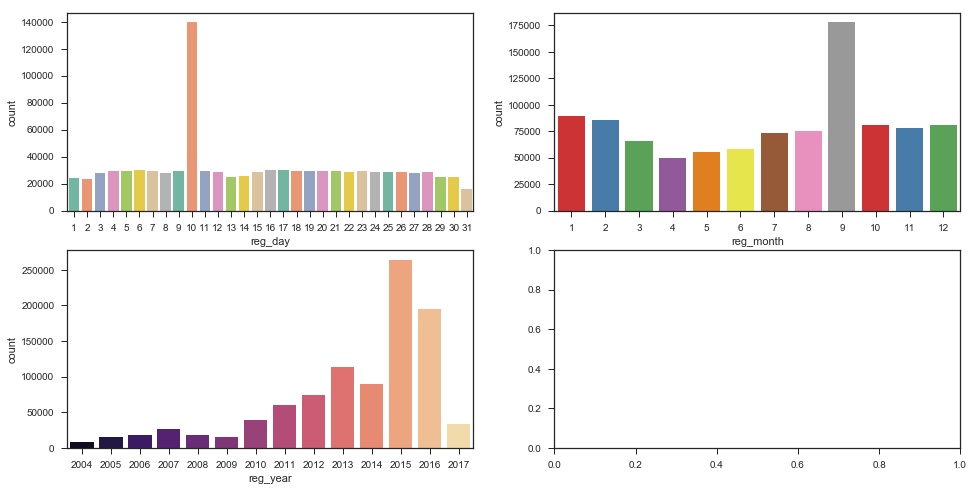

In [25]:
fig,ax = plt.subplots(2,2,figsize=(16,8))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.countplot(train['reg_day'],palette='Set2',ax=ax1)
sns.countplot(data=train,x='reg_month',palette='Set1',ax=ax2)
sns.countplot(data=train,x='reg_year',palette='magma',ax=ax3)